In [186]:
import os

import matplotlib.pyplot as plt
import random
from pennylane import numpy as np
from tqdm import tqdm
#from qbmqsp.qbm import QBM
from qbmqsp.utils import construct_multi_fcqbm_pauli_strings
from gen_data import xxz_gibbs_state, basis_encoding, gen_boltzmann_dist, gen_discrete_gauss_dist
from qbmqsp.src.utils import import_dataset, split_dataset_labels, split_data
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import scipy.linalg as spl

import pennylane as qml
from pennylane import numpy as np
from pennylane.pauli.utils import string_to_pauli_word

from qbmqsp.hamiltonian import Hamiltonian
from qbmqsp.qsp_phase_engine import QSPPhaseEngine
from qbmqsp.qevt import QEVT
from qbmqsp.rel_ent import relative_entropy



import itertools

DATASET_PATH3='C:/Users/ge84gac/datasets/o7_c5_d2_p200_1.npy'
DATASET_PATH2='C:/Users/ge84gac/Downloads/QBM-Anomaly-Detection-version-paper/QBM-Anomaly-Detection-main/src/datasets/l_o7_c5_d3_p200_v1.npy'
DATASET_PATH = 'C:/Users/ge84gac/QBM-anomaly-detection/src/datasets/l_o6_c10_d3_p1000_2.npy'   # Give dataset path
CLUSTER = 5

In [97]:
# Function returning the hamilatonian form for the restriceted boltzmann machine

In [211]:
def generate_pauli_strings_tfim(num_qubits,n_visible,restricted=True):
    """
    Generate Pauli strings for a transverse field Ising model as a 
    restricted boltzmann machine with no visible-visible connecions.
    
    Parameters:
    num_qubits (int): Number of qubits in the quantum Boltzmann machine.
    n_visible (int): Number if visible units.
    
    Returns:
    list: List of Pauli strings representing the Hamiltonian.
    """
    pauli_strings = []

    # Local transverse field terms (X_i)
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        pauli_strings.append(''.join(pauli_string))

    # Interaction terms (Z_i Z_j)
    for i, j in itertools.combinations(range(num_qubits), 2):
        if restricted:
            if i<n_visible and j>=n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))
        else:
            if i<n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))       
    return pauli_strings

generate_pauli_strings_tfim(7,3,False)   

['ZIIIIII',
 'IZIIIII',
 'IIZIIII',
 'IIIZIII',
 'IIIIZII',
 'IIIIIZI',
 'IIIIIIZ',
 'ZZIIIII',
 'ZIZIIII',
 'ZIIZIII',
 'ZIIIZII',
 'ZIIIIZI',
 'ZIIIIIZ',
 'IZZIIII',
 'IZIZIII',
 'IZIIZII',
 'IZIIIZI',
 'IZIIIIZ',
 'IIZZIII',
 'IIZIZII',
 'IIZIIZI',
 'IIZIIIZ']

In [224]:


class QBM():
    """Quantum Boltzmann machine (QBM) based on quantum signal processing.

    Parameters
    ----------
    β, enc:
        Same as attributes.
    h, θ:
        See qbmqsp.hamiltonian.Hamiltonian
    δ, polydeg:
        See qbmqsp.qsp_phase_engine.QSPPhaseEngine

    Attributes
    ----------
    β : float
        Inverse temperature.
    enc : str in {'general', 'lcu'}
        Unitary block encoding scheme.
    H : qbmqsp.hamiltonian.Hamiltonian
        Constructed from parameters (h, θ).
    qsp : qbmqsp.qsp_phase_engine.QSPPhaseEngine
        Constructed from parameters (δ, polydeg).
    qevt : qbmqsp.qevt.QEVT
        Quantum eigenvalue transform to realize matrix function f(A) = exp(- τ * |A|). Updated after each training epoch.
    observables : qml.operation.Observable
        Observables w.r.t which the QBM is measured to optimize via gradient descent.
    aux_wire, enc_wires, sys_wires, env_wires : list[int]
        Quantum register wires of quantum circuit that prepares and measures the QBM.
    """
    
    
    
    
    
    def __init__(self,data,h: list[str], θ: np.ndarray[float], enc: str, δ: float, polydeg: int, β: float, hnodes,epochs=1,restricted=True) -> None:
        if β < 0:
            raise ValueError("__init__: β must not be negative.")
        
        self.epochs=epochs
        self.β = β
        self.enc = enc
        self.H = Hamiltonian(h, θ)
        self.qsp = QSPPhaseEngine(δ, polydeg)
        self.qevt = self._construct_qevt()
        self.aux_wire, self.enc_wires, self.sys_wires, self.env_wires = self._construct_wires()
        self.observables = self._construct_obervables()
        
        self.encoded_data, bits_input_vector, num_features = self.binary_encode_data(data, use_folding=True)
        self.dim_input = bits_input_vector * num_features
        self.quantile=0.95
        self.dim_input=n_visible
        self.n_hidden_nodes=hnodes
        
        self.qubits=self.dim_input+self.n_hidden_nodes
        
        self.restricted=restricted
        # weights and biases in terms of the parameter θ
        
        #self.weights_visible_to_hidden=np.reshape(θ[self.n_hidden_nodes+self.dim_input:],(self.dim_input,self.n_hidden_nodes))
        
        #self.biases_visible=θ[0:self.dim_input]
        
        #self.biases_hidden=θ[self.dim_input:self.n_hidden_nodes+self.dim_input]

    def get_binary_cluster_points(self,dataset, cluster_index: int) -> np.ndarray:
        points = np.array([entry[:-1]
                           for entry in dataset if entry[-1] <= cluster_index])

        return self.binary_encode_data(points, use_folding=False)[0]
    
    def get_binary_outliers(self,dataset, outlier_index: int):
        outliers = np.array([entry[:-1]
                            for entry in dataset if entry[-1] >= outlier_index])

        return self.binary_encode_data(outliers, use_folding=False)[0]
  
    def binary_encode_data(self,data, use_folding=False):
        """ Encode a numpy array of form [[numpy.int64 numpy.int64] ...] into a
        list of form [[int, int, int, ...], ...].
        Example: encode [[107  73] [113  90] ...] to
        [[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0] .
        """

        # find out how many bits we need for each feature
        number_bits = len(np.binary_repr(np.amax(data)))
        number_features = data.shape[1]

        binary_encoded = ((data.reshape(-1, 1) & np.array(2 **
                          np.arange(number_bits-1, -1, -1))) != 0).astype(np.float32)
        if use_folding:
            return binary_encoded.reshape(len(data), number_features*number_bits), number_bits, number_features
        else:
            return binary_encoded.reshape(len(data), number_features, number_bits), number_bits, number_features
    
    
    def n_qubits(self, registers: str | set[str] = None) -> int:
        """Return number of qubits per registers.
        
        Parameters
        ----------
        registers : str | set[str]
            Quantum registers whose number of qubits should be returned.
            Must be an element from or a subset of {'aux', 'enc', 'sys', 'env'}.

        Returns
        -------
        n : int
            Number of qubits used per registers.
        """
        if registers is None:
            registers = {'aux', 'enc', 'sys', 'env'}
        elif type(registers) == str:
            registers = {registers}
        if not registers.issubset({'aux', 'enc', 'sys', 'env'}):
            raise ValueError("n_qubits: registers must be an element from or a subset of %r." % {'aux', 'enc', 'sys', 'env'})
        
        n = 0
        if 'env' in registers:
            n += self.qevt.n_qubits('sys')
        registers.discard('env')
        if len(registers) != 0:
            n += self.qevt.n_qubits(registers)
        return n

    def _generate_qsp_phases(self) -> np.ndarray[float]:
        τ = self.β / (1-self.qsp.δ) * self.H.θ_norm()
        φ = self.qsp.generate(τ)
        return φ

    def _construct_qevt(self) -> QEVT:
        φ = self._generate_qsp_phases()
        h_δ, θ_δ = self.H.preprocessing(self.qsp.δ)
        return QEVT(h_δ, θ_δ, self.enc, φ)
    
    def _construct_wires(self) -> tuple[list[int], list[int], list[int], list[int]]:
        wires = list(range(self.n_qubits()))
        aux_wire = wires[: self.n_qubits('aux')]
        enc_wires = wires[self.n_qubits('aux') : self.n_qubits({'aux', 'enc'})]
        sys_wires = wires[self.n_qubits({'aux', 'enc'}) : self.n_qubits({'aux', 'enc', 'sys'})]
        env_wires = wires[self.n_qubits({'aux', 'enc', 'sys'}) : self.n_qubits({'aux', 'enc', 'sys', 'env'})]
        return aux_wire, enc_wires, sys_wires, env_wires

    def _construct_obervables(self) -> list[qml.operation.Observable]:
        n_aux_enc = self.n_qubits({'aux', 'enc'})
        aux_enc_wires = self.aux_wire + self.enc_wires
        proj0 = qml.Projector( [0] * n_aux_enc, aux_enc_wires)

        new_sys_wires = list(range(self.n_qubits('sys')))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        observables = [proj0] + [proj0 @ string_to_pauli_word(self.H.h[i], wire_map) for i in range(self.H.n_params)]
        return observables
    
    def _bell_circuit(self) -> None:
        for i, j in zip(self.sys_wires, self.env_wires):
            qml.Hadamard(i)
            qml.CNOT([i, j])

    def probabilistic(self):
        
        bit_strings=[]
        for i in range(2**(self.n_hidden_nodes+self.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes+self.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
        sample = random.choices(bit_strings, k=1)

        for i,x in enumerate(sample[0]):
            if x==1:
                qml.PauliX(wires=[self.sys_wires[i]])
    
    def _prepare(self) -> None:
        self._bell_circuit()
        #self.probabilistic()
        self.qevt.circuit(self.aux_wire, self.enc_wires, self.sys_wires)
    
    def _measure(self) -> None:
        #return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        return [qml.expval(self.observables[i]) for i in range(len(self.observables))]
    
    
    def get_sample(self,shots=1):
        dev = qml.device(dev_name,shots=shots, wires=self.n_qubits({'aux','enc','sys'}))
        @qml.qnode(dev)
        
        def quantum_circuit():
            
            self._prepare()
            return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        
        sample=quantum_circuit()
        return sample
    
    def get_average_configuration_from_samples(self, samples: list, input_vector=None):
        ''' Takes samples from Annealer and averages for each neuron and connection
        '''

        # unclamped if input_vector == None
        unclamped = input_vector== None

        # biases (row = sample, column = neuron)
        np_samples = np.vstack(
            tuple([np.array(list(sample.values())) for sample in samples]))
        avgs_biases = np.average(np_samples, axis=0)
        avgs_biases_hidden = avgs_biases[self.dim_input:] if unclamped else avgs_biases
        avgs_biases_visible = avgs_biases[:
                                          self.dim_input] if unclamped else input_vector

        # weights
        avgs_weights_visible_to_hidden = np.zeros(
            self.weights_visible_to_hidden.shape)
        if not self.restricted:
            avgs_weights_visible_to_visible = np.zeros(
                self.weights_visible_to_visible.shape)
        for v in range(self.dim_input):
            # visible to hidden connections
            for h in range(self.n_hidden_nodes):
                x, y = (np_samples[:, v], self.dim_input +
                        h) if unclamped else (input_vector[v], h)
                avgs_weights_visible_to_hidden[v, h] = np.average(
                    x*np_samples[:, y])
            # visible to visible connections
            if not self.restricted:
                for v2 in range(v, self.dim_input):
                    x, y = (np_samples[:, v], np_samples[:, v2]) if unclamped else (
                        input_vector[v], input_vector[v2])
                    avgs_weights_visible_to_visible[v, v2] = np.average(x*y)

        if self.restricted:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, None
        else:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, avgs_weights_visible_to_visible

    def _compute_expvals(self) -> np.ndarray[float]:
        dev = qml.device(dev_name,wires=self.n_qubits({'aux','enc','sys','env'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
        @qml.qnode(dev)
        
        def quantum_circuit():
            self._prepare()
            return self._measure()
        num_repetitions=1
        avg_measurements=np.zeros(self.H.n_params)
        for repetitions in range(num_repetitions):
            
            measurements = quantum_circuit()
            
            success_probabilty = measurements[0]
            
            
            qbm_expvals = measurements[1:] / success_probabilty
            
            avg_measurements+=qbm_expvals
            
            print(success_probabilty, "prob")
        
        
        avg_measurements=avg_measurements/float(num_repetitions)
        
       
        return avg_measurements
    
    def _loss_func(self, ρ0: np.ndarray[float], ρ1: np.ndarray[float]) -> float:
        return relative_entropy(ρ0, ρ1, check_state=True).item()
    
    def assemble(self) -> np.ndarray[float]:
        """Assemble QBM."""
        expH = spl.expm(-self.β * self.H.assemble())
        return expH / np.trace(expH)
    
    
    def get_energy(self,input_vector):
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        
        
    # List to store all bit strings
        bit_strings=[]
        p=[]
    # There are 2^n bit strings of length n
        print(new_biases)
        for i in range(2**self.n_hidden_nodes):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes)
             
            bit_list = np.array([1-2*int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            p.append(np.exp(-self.β*np.dot(bit_list,new_biases)))

        p=np.array(p)
        probabilities=p/np.sum(p)
        sample = random.choices(bit_strings, weights=probabilities, k=1)

        return self.β*np.dot(sample,new_biases)
            

               

            
     
    
    def free_energy(self, input_vector):
        '''Function to compute the free energy'''

        # calculate hidden term
        
         
         
        hidden_term = self.get_energy(input_vector)

        # calculate visible_term
        # visible bias
        visible_term = self.β*np.dot(
            1-2*np.array(input_vector), self.H.θ[:self.dim_input]) #/beta
        
        

        return hidden_term + visible_term
    
    def calculate_outlier_threshold(self, quantile=0.95):
        self.quantile = quantile
        energies = np.apply_along_axis(
            self.free_energy, axis=1, arr=self.encoded_data)
        self.outlier_threshold = np.quantile(energies, self.quantile)
    
    
    
    
    
    def get_average_configurations(self,input_vector=None):
        '''
        Function for giving averge configurations of all qubits for the gibbs state of the system.
        Gives configuration over hidden units only, if input vector is clamped at a certain value.
       
    
        Parameters:
        input vector (np.ndarray)
        
    
        Returns:
        list: List of expectation values of hamilatonian terms.
        '''
        
        
        # unclamped values
        if input_vector is None:
            
            qbm_expvals=self._compute_expvals()
            
            return qbm_expvals
        
        # clamped values
        
        
        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            
            self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ)
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        #np.matmul(input_vector, self.weights_visible_to_hidden).flatten()
        
        Q_new=new_biases

        exp_vals=-np.tanh(self.β*new_biases)
        return exp_vals
            
        '''
        
        β, δ, θ_norm = self.β, 0.3, np.linalg.norm(Q_new, ord=1)
        τ = β * θ_norm / (1-δ)
        
        φ = self.qsp.generate(τ)
        #del qsp_phase_engine
         
      
        # New energy configuration only for hidden units
        h=generate_pauli_strings_tfim(self.n_hidden_nodes,self.n_hidden_nodes)
        
        h_δ = h + [self.n_hidden_nodes * 'I']
        θ_δ = np.append(Q_new * (1-δ)/(2*θ_norm), (1+δ)/2)
        encoding='general' 
        qevt = QEVT(h_δ, θ_δ, encoding, φ)
        
        
        
        n_aux, n_enc, n_sys = qevt.n_qubits({'aux'}), qevt.n_qubits({'enc'}), qevt.n_qubits({'sys'})
        wires = list(range(n_aux + n_enc + 2*n_sys))
        aux_wire = wires[: n_aux]
        enc_wires = wires[n_aux : n_aux+n_enc]
        sys_wires = wires[n_aux+n_enc : n_aux+n_enc+n_sys]
        env_wires=wires[n_aux+n_enc+n_sys:]
        
        new_sys_wires = list(range(n_sys))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        proj0 = qml.Projector( [0] * (n_aux+n_enc), aux_wire+enc_wires)
        observables = [proj0] + [proj0 @ string_to_pauli_word(h[i], wire_map) for i in range(len(h))]
        
        
        dev = qml.device(dev_name, wires=n_aux+n_enc+2*n_sys)
        #dev = qml.device(, backend=backend,wires=n_aux+n_enc+2*n_sys,ibmqx_token=token)
        @qml.qnode(dev)
        
        
        def qevt_circuit():
            for i, j in zip(sys_wires, env_wires):
                qml.Hadamard(i)
                qml.CNOT([i, j])
            qevt.circuit(aux_wire, enc_wires, sys_wires)
            return [qml.expval(observables[i]) for i in range(len(observables))]
       
        measurements = qevt_circuit()
        success_probabilty = measurements[0]
        qbm_expvals = measurements[1:] / success_probabilty    
        
        return qbm_expvals
    
        '''
            
        
        
    def train_for_one_iteration(self, batch, learning_rate):

        errors = 0
        #errors_biases_visible = 0
        #errors_weights_visible_to_hidden = 0
        #if not self.restricted:
          #  errors_weights_visible_to_visible = 0

        for i,input_vector in enumerate(batch):
            
            
            if i==0:
                unclamped_config = self.get_average_configurations() 
                print(unclamped_config)
            
            clamped_config = self.get_average_configurations(input_vector) # has only expectations over hidden units
            
            # avgs_weights_visible_to_visible_clamped only has a value if not restricted
            print(clamped_config)
            
            # Getting averages for all qubits , avg_visible=input_vector
            
            full_clamped_config=np.zeros_like(unclamped_config)
            
            full_clamped_config[:self.dim_input]=1+(-2)*input_vector   
            full_clamped_config[self.dim_input:self.dim_input+self.n_hidden_nodes]=clamped_config
            
            pos_neg=1-2*input_vector
            if self.restricted:
                
                
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.kron(pos_neg,clamped_config)
            
            else:
                
                
                
                visible=list(pos_neg[j]*pos_neg[i] for j in range(len(pos_neg)) for i in range(j+1,len(pos_neg)))
                hidden=np.kron(pos_neg,clamped_config)
                for i in range(1,self.dim_input+1):
                    for j in range(self.n_hidden_nodes):
                        visible.insert((i-1)*self.n_hidden_nodes+(i)*(self.dim_input-1)-(i-1)+j,hidden[self.n_hidden_nodes*(i-1)+j])
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.array(visible)
            
            errors += full_clamped_config - unclamped_config
            
            
            
            
            
            
            

        errors /= batch.shape[0]
        
        self.H.θ = self.H.θ - learning_rate * errors
                
        self.qevt = self._construct_qevt()
                
       
        
        
        return np.average(errors[:self.dim_input]**2)
    
    
    
    
    def train_model(self, batch_size=8, learning_rate=0.005):
        
        data = self.encoded_data
        
        batch_num = data.shape[0] // batch_size
        diff = data.shape[0] % batch_size
        if diff:
            
        
            data = data[:-diff]
            last_batch = data[data.shape[0] - diff:]
        
        
        
        batches = np.vsplit(data, batch_num)
        
        if diff:
            batches.append(last_batch)
              
        losses=[]
        
        for epoch in range(1, self.epochs+1):
            print(f'Epoch {epoch}')
            batch_errors = None
            batchnum = 1
            errors_f=[]
            for batch in tqdm(batches):
                    print(batch)
                    errors = self.train_for_one_iteration(batch, learning_rate)
                    print(errors)
                    if type(batch_errors) is np.ndarray:
                        batch_errors = np.hstack((batch_errors, errors))
                    else:
                        batch_errors = errors
                    #self.save_weights(
                        #f'e{epoch}_b{batchnum}_{self.paramstring}')
                    batchnum += 1
               
                    #self.save_weights(
                     #   f'e{epoch}_b{batchnum}_{self.paramstring}')
                    #raise e
                    errors_f.append(errors)
        
        
        losses.append(errors_f)
        self.calculate_outlier_threshold(self.quantile)
        return losses  
    #self.error_container.add_error(batch_errors)
        #self.error_container.plot("qbm_errors" + self.paramstring)
        #self.save_weights(title="final_weights_qbm" + self.paramstring)
        # make list of values of the error dicts
        
        #self.calculate_outlier_threshold(self.quantile)
       
    def predict_point_as_outlier(self, input):
        energy = self.free_energy(input)
        if energy >= self.outlier_threshold:
            return 1, energy
        return 0, energy
        
    
    def get_weights(self,Q):
        weights_vh_vv=list(Q[self.dim_input+self.n_hidden_nodes:])
            
        for i in range(1,self.dim_input+1):
            for j in range(i):
                weights_vh_vv.insert((self.dim_input+self.n_hidden_nodes)*(i-1)+j,0)
            
        weights_vh_vv=np.array(weights_vh_vv)
        weights_visible_to_visible=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,0:self.dim_input]
        weights_visible_to_hidden=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,self.dim_input:]
    
        return weights_visible_to_visible,weights_visible_to_hidden
    
         
        
     
    

    

In [225]:

#dev_name='qiskit.ibmq'
data = import_dataset(DATASET_PATH2)
training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)

print(training_labels[0::])
import numpy
training_data=numpy.expand_dims(training_data[:,0],axis=1)
training_data=training_data[0::]
n_hidden_units=3
n_visible=7
n_qubits = n_visible+n_hidden_units

restricted=False
h = generate_pauli_strings_tfim(n_qubits,n_visible,restricted)
print(h)
nparams = len(h)
np.random.seed(seed=1)
θ_init = np.loadtxt('./weights_7_3_un.txt')
enc = 'general'
δ = 0.3
polydeg = 10
β = 1.0
learning_rate = 0.001
epochs = 1


dev_name='default.qubit'
#dev_name='lightning.qubit'

qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs,restricted)

errors=qbm.train_model(504,learning_rate)

[ 4  3  0  0  3  1  2  0  2  0  4  3  1  0  4  3  3  2  2  1  4  1  3  3
  0  4  0  3  2  4  3  2  2  4  3  4  4  0  4  4  3  3  2  4  3  3  1  4
  1  1  4  2  0  1  4  0  3  3  0  2  4  0  4  2  2  1  2  3  3  1  3  4
  4  0  1  4  4  2  1  2  1  1  1  4  3  3  4  2  4  1  3  2  4  0  4  0
 11  0  2  1  4  4  0  0  3  0  4  1  1  1  2  1  4  3  2  1  3  0  0  2
  3  4  0  3  2  4  2  9  1  0  0  3  0  4  0  3  1  4  1  4  3  1  1  2
  2  2  4  3  0  1  2  0  0  0  3  0  3  2  2  2  0  3  2  4  3  2  4  3
  1  0  4  2  0  0  3  0  1  1  1  0  2  0  4  1  3  1  2  2  0  1  0  3
  2  3  0  4  1  3  1  3  4  4  2  4  3  4  0  3  1  1  1  4  1  0  4  2
  1  1  1  0  3  1  0  0  0  2  0  4  1  3  4  4  3  2  4  0  3  2  2  0
  1  2  4  1  1  2  2  2  1  4  4  1  4  4  4  3  3  4  3  2  3  1  4  3
  2  4  2  1  4  0  2  4  2  1  2  2  1  2  0  4  1  3  2  1  1  0  4  0
  0  0  0  4  4  2  0  2  3  0  4  3  4  0  4  3  0  0  0  4  3  2  4  0
  3  1  2  3  2  0  2  3  1  1  0  1  2  1  2  1  2

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
0.00022839900257601038 prob
[-8.69272354e-02  3.24701965e-01  3.14571581e-01 -1.08465214e-01
 -1.17015696e-01  8.79506587e-02 -6.35096880e-02  2.88031022e-02
  9.65122010e-03 -1.33811695e-02  8.07300029e-02  5.82815551e-02
 -2.96742306e-01  3.44944896e-01 -4.91204773e-02 -4.80385742e-02
  3.50409713e-02  1.50599894e-05 -5.89958199e-04  4.33350527e-01
 -4.41718906e-01 -1.63531197e-01 -1.60053756e-02 -1.20683495e-01
  7.58637154e-02  2.42219344e-02 -3.40781825e-03 -2.37713230e-01
  2.06040084e-03  1.85051016e-01  1.78685897e-02  7.38911577e-02
  5.42070028e-02 -2.90871034e-03 -5.10416957e-02  1.18068170e-01
  1.30011475e-01 -7.98782186e-02 -4.43877601e-02  3.73450212e-03
 -5.85945581e-02  1.02188987e-02  1.81598134e-03 -8.17366969e-03
 -7.39490106e-03  1.29914506e-02 -1.38095712e-02  3.95229476e-03
 -1.02480912e-02 -1.82164220e-02 -8.

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.08s/it]

0.005115558232748697
[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[-0.05465702  0.05096701 -0.0068577 ]
[-0.10820846 -0.04456678  0.05124191]
[-0.14132642 -0.04810067  0.02896315]
[-0.04036064  0.04837064  0.02198804]
[-0.11876426 -0.09542557  0.0110383 ]
[0.1353554  0.08650294 0.03158993]
[-0.14132642 -0.04810067  0.02896315]
[0.1353554  0.08650294 0.03158993]
[-0.12250483 -0.04197041  0.02239617]
[ 0.00437429 -0.00265535  0.02092438]
[-0.05465702  0.05096701 -0.0068577 ]
[-0.11876426 -0.09542557  0.0110383 ]
[-0.12250483 -0.04197041  0.02239617]
[ 0.00437429 -0.00265535  0.02092438]
[0.00807325 0.00188248 0.01203735]
[0.04119121 0.00541637 0.03431611]
[0.1353554  0.08650294 0.03158993]
[0.15229988 0.07489617 0.00279668]
[-0.09994268 -0.08929531  0.00447132]
[-0.04116294  0.01414416 -0.00797384]
[-0.0856463  -0.09189168  0.03331705]
[0.04119121 0.00541637 0.03431611]
[-0.05465702  0.05096701 -0.0068577 ]
[-0.14132642 -0.04810067  0.02896315]
[-0.02686657  0.01154779  0.02087189]


[0.15229988 0.07489617 0.00279668]
[ 0.00437429 -0.00265535  0.02092438]
[-0.05465702  0.05096701 -0.0068577 ]
[-0.13306064 -0.0928292  -0.01780744]
[-0.14132642 -0.04810067  0.02896315]
[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[0.16659625 0.07229981 0.03164241]
[-1.55622795e-01 -4.55043016e-02  1.17414820e-04]
[-0.10820846 -0.04456678  0.05124191]
[0.02689483 0.00801274 0.00547037]
[-0.11008557 -0.0623038   0.02901564]
[-0.13306064 -0.0928292  -0.01780744]
[-0.09994268 -0.08929531  0.00447132]
[-0.0856463  -0.09189168  0.03331705]
[-0.12250483 -0.04197041  0.02239617]
[0.16659625 0.07229981 0.03164241]
[-0.06747931  0.025995   -0.03450153]
[ 0.00437429 -0.00265535  0.02092438]
[-0.11876426 -0.09542557  0.0110383 ]
[0.02689483 0.00801274 0.00547037]
[-0.0856463  -0.09189168  0.03331705]
[0.13347829 0.06876592 0.00936366]
[0.16659625 0.07229981 0.03164241]
[-0.06747931  0.025995   -0.03450153]
[-0.09994268 -0.08929531  0.00447132]
[-0.14132642 -0.04810067  0.02896315]
[0.041191

[ 3  3  0  0  3  1  2  0  2  0  4  3  1  0  3  4  3  2  2  1  3  1  3  3
  0  4  0  3  2  3  3  2  2  4  3  4  4  0  4  4  3  3  2  4  4  4  1  3
  1  1  4  2  0  1  4  0  3  3  0  2  4  0  3  4  2  1  2  3  2  1  3  3
  3  0  1  4  3  2  1  2  1  1  1  4  3  2  4  3  4  1  9  2  4  0  4  0
  7  0  2  1  4  4  0  0  3  0  4  1  1  1  2  1  4  3  2  1  3  0  0  2
  3  4  0  3  2  4  2 11  1  0  0  3  0  3  0  3  1  4  1  3  3  1  1  2
  2  2  3  4  0  1  2  0  0  0  3  0  3  2  2  2  0  3  2  4  4  2  3  3
  1  0  4  2  0  0  4  0  1  1  1  0  2  0  4  1  3  1  2  2  0  1  0  4
  2  3  0  4  1  3  1  3  4  4  2  4  3  2  0  3  1  1  1  4  1  0  4  2
  1  1  1  0  4  1  0  0  0  3  0  3  1  2  4  4  3  2  4  0  3  2  2  0
  1  4  4  1  1  2  2  2  1  4  4  1  2  4  4  3  4  4  3  2  3  1  4  3
  2  4  2  1  4  0  2  4  2  1  2  1  2  0  4  1  4  2  1  1  0  4  0  0
  0  0  4  4  2  0  2  3  0  4  4  4  0  4  3  0  0  0  4  3  2  4  0  3
  1  2  4  2  0  2  3  1  1  0  1  2  1  2  1  2  4

([<matplotlib.axis.XTick at 0x2368f6f3e10>,
 [Text(0, 0, '0b0'),
  Text(5, 0, '0b101'),
  Text(10, 0, '0b1010'),
  Text(15, 0, '0b1111'),
  Text(20, 0, '0b10100'),
  Text(25, 0, '0b11001'),
  Text(30, 0, '0b11110'),
  Text(35, 0, '0b100011'),
  Text(40, 0, '0b101000'),
  Text(45, 0, '0b101101'),
  Text(50, 0, '0b110010'),
  Text(55, 0, '0b110111'),
  Text(60, 0, '0b111100'),
  Text(65, 0, '0b1000001'),
  Text(70, 0, '0b1000110'),
  Text(75, 0, '0b1001011'),
  Text(80, 0, '0b1010000'),
  Text(85, 0, '0b1010101'),
  Text(90, 0, '0b1011010'),
  Text(95, 0, '0b1011111'),
  Text(100, 0, '0b1100100'),
  Text(105, 0, '0b1101001'),
  Text(110, 0, '0b1101110'),
  Text(115, 0, '0b1110011'),
  Text(120, 0, '0b1111000'),
  Text(125, 0, '0b1111101')])

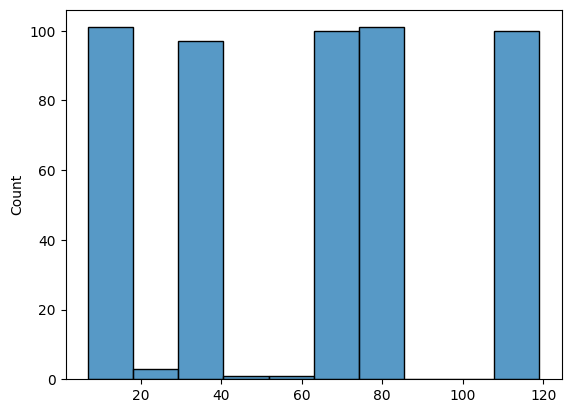

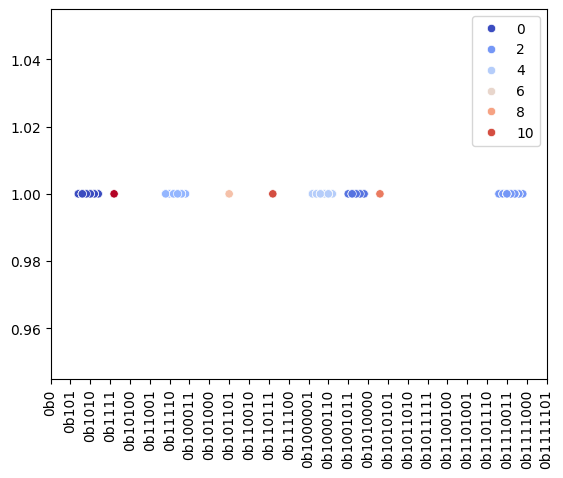

In [226]:

data = import_dataset(DATASET_PATH2)
training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)

print(training_labels)
import seaborn as sns
import numpy
sns.histplot(training_data[:,0])
plt.figure()
#training_labels
sns.scatterplot(x=training_data[:,0],y=np.ones_like(training_data[:,0]), hue=training_labels,palette='coolwarm')
ticks=np.arange(0,127,5)
plt.xticks(ticks=ticks,rotation=90,labels=[bin(tick) for tick in ticks])

(<Figure size 6400x2300 with 1 Axes>, <Axes: >)

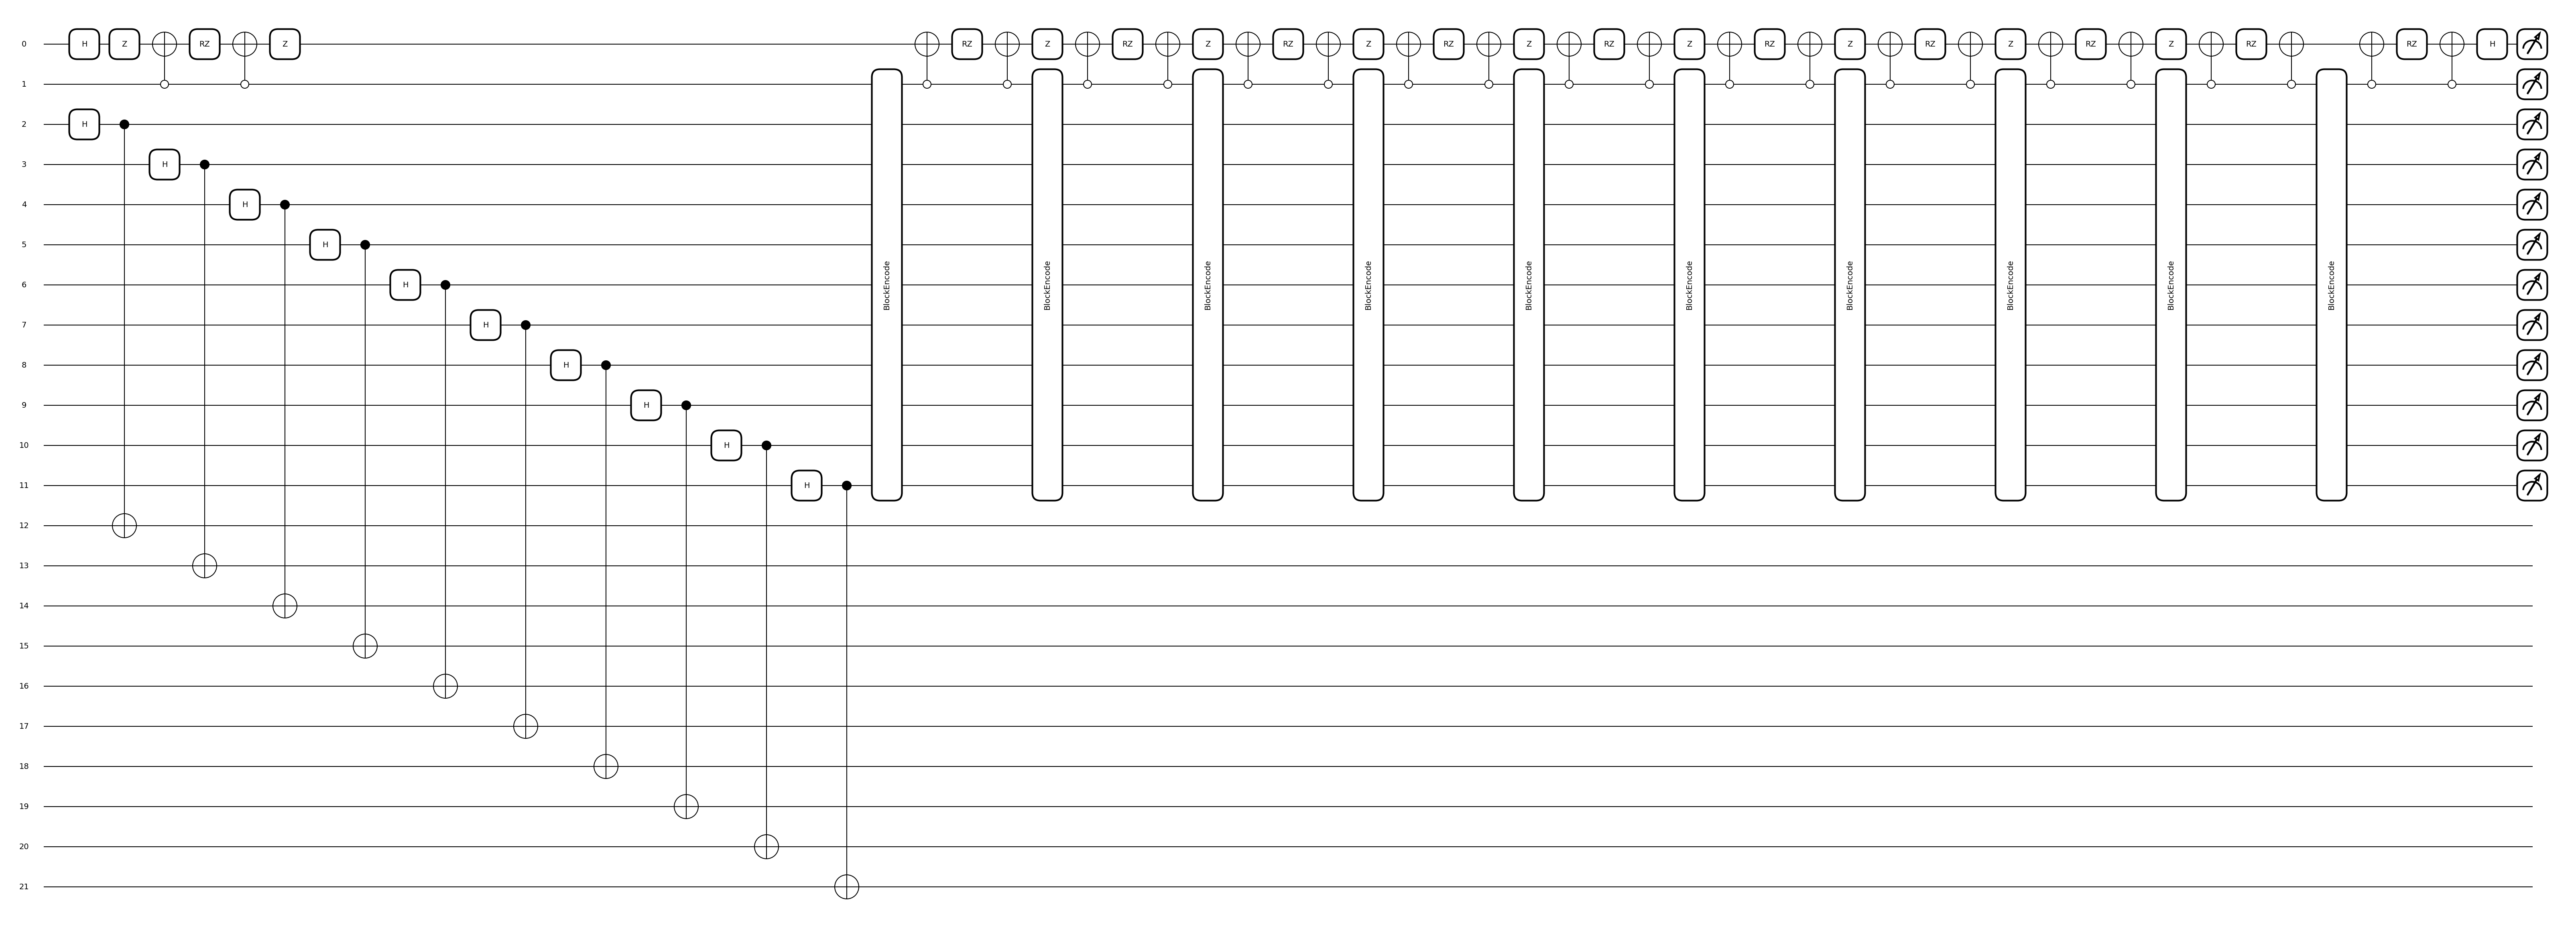

In [114]:
dev = qml.device(dev_name, wires=qbm.n_qubits({'aux','enc','sys'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
@qml.qnode(dev)
def quantum_circuit():
    qbm._prepare()
    return qbm._measure()

qml.draw_mpl(quantum_circuit)()

In [90]:
bit_strings=[]
for i in range(2**(qbm.n_hidden_nodes+qbm.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(qbm.n_hidden_nodes+qbm.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
sample = random.choices(bit_strings, k=1)

sample[0]

tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 0], requires_grad=True)

In [ ]:
import time

start=time.time()
#x=qbm.get_sample(shots=5)
x=qbm.get_average_configurations()
end=time.time()
print(x)
print(end-start)

[[[1. 1. 0. 1. 1. 1. 0.]]

 [[0. 0. 0. 1. 0. 1. 0.]]

 [[0. 1. 0. 1. 0. 1. 0.]]]
[[[1. 0. 0. ... 1. 0. 1.]]

 [[0. 0. 0. ... 0. 1. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]]

 ...

 [[1. 1. 1. ... 0. 1. 0.]]

 [[1. 0. 0. ... 1. 0. 0.]]

 [[1. 0. 0. ... 1. 1. 0.]]]
[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[-0.05465702  0.05096701 -0.0068577 ]
[-0.10820846 -0.04456678  0.05124191]
[-0.14132642 -0.04810067  0.02896315]
[-0.04036064  0.04837064  0.02198804]
[-0.11876426 -0.09542557  0.0110383 ]
[0.1353554  0.08650294 0.03158993]
[-0.14132642 -0.04810067  0.02896315]
[0.1353554  0.08650294 0.03158993]
[-0.12250483 -0.04197041  0.02239617]
[ 0.00437429 -0.00265535  0.02092438]
[-0.05465702  0.05096701 -0.0068577 ]
[-0.11876426 -0.09542557  0.0110383 ]
[-0.12250483 -0.04197041  0.02239617]
[ 0.00437429 -0.00265535  0.02092438]
[0.00807325 0.00188248 0.01203735]
[0.04119121 0.00541637 0.03431611]
[0.1353554  0.08650294 0.03158993]
[0.15229988 0.07489617 0.00279668]
[-0.09994268 -0.08929531  0.0

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 859.61it/s]


[-0.05938518 -0.13467875  0.00650517]
[-0.14132642 -0.04810067  0.02896315]
[-0.08194734 -0.08735385  0.02443002]
Calculate cluster energy


 38%|██████████████████████████████                                                 | 190/500 [00:00<00:00, 828.59it/s]

[-0.09994268 -0.08929531  0.00447132]
[-0.14132642 -0.04810067  0.02896315]
[0.04119121 0.00541637 0.03431611]
[-0.14132642 -0.04810067  0.02896315]
[0.16847336 0.09003683 0.05386868]
[-0.04116294  0.01414416 -0.00797384]
[0.16659625 0.07229981 0.03164241]
[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[-0.04036064  0.04837064  0.02198804]
[-0.02874367 -0.00618923 -0.00135438]
[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[-0.04116294  0.01414416 -0.00797384]
[-0.14132642 -0.04810067  0.02896315]
[0.12105903 0.08909931 0.00274419]
[0.12105903 0.08909931 0.00274419]
[ 0.00437429 -0.00265535  0.02092438]
[-0.0856463  -0.09189168  0.03331705]
[-0.14132642 -0.04810067  0.02896315]
[-0.09994268 -0.08929531  0.00447132]
[0.12105903 0.08909931 0.00274419]
[-0.11876426 -0.09542557  0.0110383 ]
[-0.11876426 -0.09542557  0.0110383 ]
[0.15229988 0.07489617 0.00279668]
[-0.02153906  0.0545009   0.01542106]
[-0.11876426 -0.09542557  0.0110383 ]
[-0.12250483 -0.04197041  0.02239617]
[ 0.00437

 73%|█████████████████████████████████████████████████████████▊                     | 366/500 [00:00<00:00, 829.03it/s]

[-1.55622795e-01 -4.55043016e-02  1.17414820e-04]
[-0.05465702  0.05096701 -0.0068577 ]
[0.16659625 0.07229981 0.03164241]
[-0.02874367 -0.00618923 -0.00135438]
[-0.05465702  0.05096701 -0.0068577 ]
[0.1353554  0.08650294 0.03158993]
[-0.02874367 -0.00618923 -0.00135438]
[-0.14132642 -0.04810067  0.02896315]
[0.1353554  0.08650294 0.03158993]
[-0.05465702  0.05096701 -0.0068577 ]
[-0.0856463  -0.09189168  0.03331705]
[-0.14132642 -0.04810067  0.02896315]
[-0.12250483 -0.04197041  0.02239617]
[-0.05465702  0.05096701 -0.0068577 ]
[0.16659625 0.07229981 0.03164241]
[-0.05465702  0.05096701 -0.0068577 ]
[0.16659625 0.07229981 0.03164241]
[-0.10820846 -0.04456678  0.05124191]
[0.12105903 0.08909931 0.00274419]
[-0.11876426 -0.09542557  0.0110383 ]
[-0.09994268 -0.08929531  0.00447132]
[-0.10820846 -0.04456678  0.05124191]
[-0.10820846 -0.04456678  0.05124191]
[-0.05465702  0.05096701 -0.0068577 ]
[-0.04304005 -0.00359287 -0.03020011]
[0.04119121 0.00541637 0.03431611]
[0.04119121 0.0054163

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 807.51it/s]

[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[-0.13118353 -0.07509218  0.00441883]
[-0.04304005 -0.00359287 -0.03020011]
[-0.11008557 -0.0623038   0.02901564]
[-0.04304005 -0.00359287 -0.03020011]
[-0.13306064 -0.0928292  -0.01780744]
[-0.12250483 -0.04197041  0.02239617]
[0.15229988 0.07489617 0.00279668]
[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[-0.12250483 -0.04197041  0.02239617]
[-0.0856463  -0.09189168  0.03331705]
[0.04119121 0.00541637 0.03431611]
[-0.05465702  0.05096701 -0.0068577 ]
[-0.14132642 -0.04810067  0.02896315]
[-0.12250483 -0.04197041  0.02239617]
[-0.0856463  -0.09189168  0.03331705]
[0.04119121 0.00541637 0.03431611]
[-0.05465702  0.05096701 -0.0068577 ]
[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[-0.05465702  0.05096701 -0.0068577 ]
[-9.92208747e-03 -5.89802166e-05 -7.92135515e-03]
[-0.11876426 -0.09542557  0.0110383 ]
[-0.10820846 -0.04456678  0.05124191]
[-0.10820846 -0.04456678  0.05124191]

<Axes: title={'center': 'Predicted Points'}>

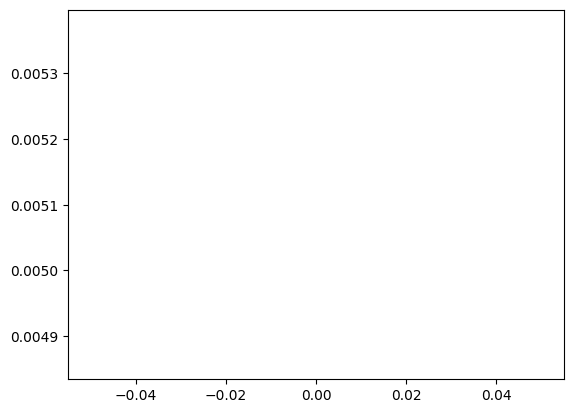

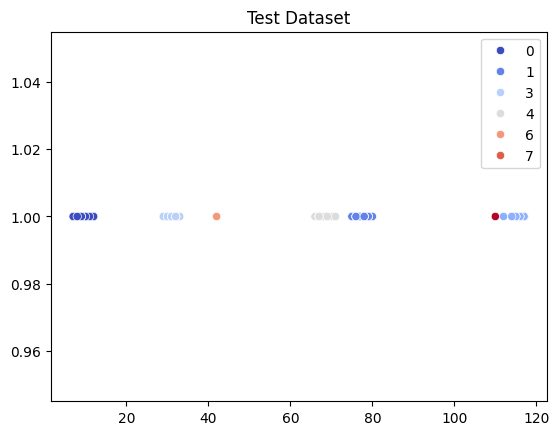

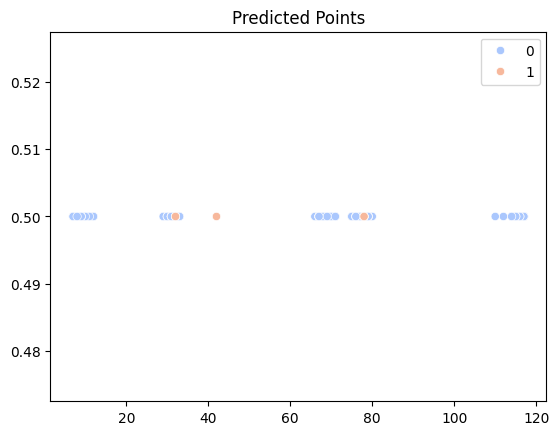

In [236]:
#weights=qbm.H.θ

plt.plot(errors)
testing_data, testing_labels = split_dataset_labels(testing_dataset)
encoded_data_test, bits_input_vector, num_features = qbm.binary_encode_data(
        testing_data, use_folding=True)




#training_data=numpy.expand_dims(training_data[:,0],axis=1)
outliers = qbm.get_binary_outliers(
dataset=testing_dataset, outlier_index=CLUSTER)
outliers=numpy.expand_dims(outliers[:,0],axis=1)
print(outliers)

points = qbm.get_binary_cluster_points(
dataset=testing_dataset, cluster_index=CLUSTER - 1)

points=numpy.expand_dims(points[:,0],axis=1)
print(points)
predict_points_cluster = np.zeros(len(points), dtype=int)
predict_points_outliers = np.zeros(len(outliers), dtype=int)
qbm.calculate_outlier_threshold(.90)
print("Outlier threshold: ", qbm.outlier_threshold)
print("Calculate outlier Energy")

outlier_energy = []
for index, outlier in enumerate(tqdm(outliers), 0):
    outlier = np.reshape(outlier, (qbm.dim_input))
    predict_points_outliers[index], this_outlier_energy = qbm.predict_point_as_outlier(
        outlier)
    outlier_energy.append(this_outlier_energy)
outlier_energy = np.array(outlier_energy)

o = outlier_energy.reshape((outlier_energy.shape[0]))

print("Calculate cluster energy")
cluster_point_energy = []

for index, point in enumerate(tqdm(points), 0):
    point = np.reshape(point, (qbm.dim_input))
    predict_points_cluster[index], this_cluster_point_energy = qbm.predict_point_as_outlier(
        point)
    cluster_point_energy.append(this_cluster_point_energy)
cluster_point_energy = np.array(cluster_point_energy)

c = cluster_point_energy.reshape((cluster_point_energy.shape[0]))

title='test'
#qbmqsp.src.utils.save_output(title="cluster_" + title, object=c)
#QBM.plot_energy_diff([o, c], qbm.outlier_threshold, title + ".pdf")

#QBM.plot_hist(c, o, qbm.outlier_threshold, "qbm_hist" + ".pdf")

########## OUTLIER CLASSIFICATION ##########
print('Outlier classification: Results...')
predict_points = np.concatenate(
    (predict_points_cluster, predict_points_outliers))

print("Predicted points test: ", predict_points)

true_points = np.concatenate(
    (np.zeros_like(cluster_point_energy), np.ones_like(outlier_energy)))

accuracy, precision, recall = accuracy_score(true_points, predict_points), precision_score(
    true_points, predict_points), recall_score(true_points, predict_points)
f1 = f1_score(true_points, predict_points)
tn, fp, fn, tp = confusion_matrix(
    true_points, predict_points, labels=[0, 1]).ravel()

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, \nNum True Negative: {tn}, Num False Negative: {fn}, Num True Positive: {tp}, Num False Positive: {fp}')

#print(f'Wallclock time: {(end-start):.2f} seconds')

print("Outlier threshold: ", qbm.outlier_threshold)
print("Average clusterpoint energy: ", np.average(cluster_point_energy))
print("Outlier energy: ", outlier_energy)
plt.figure()
plt.title('Test Dataset')
sns.scatterplot(x=testing_data[:,0],y=np.ones_like(testing_data[:,0]), hue=testing_labels,palette='coolwarm')
plt.figure()
plt.title('Predicted Points')
sns.scatterplot(x=testing_data[:,0],y=0.5*np.ones_like(testing_data[:,0]), hue=predict_points,palette='coolwarm')

In [132]:
np.average((1-2*qbm.encoded_data[:,1])*(1-2*qbm.encoded_data[:,5]))

tensor(-0.05555556, dtype=float32, requires_grad=True)

In [ ]:
dev = qml.device('default.qubit', wires=qbm.n_qubits())
@qml.qnode(dev)
def quantum_circuit():
    qbm._prepare()
    return qbm._measure()


qml.draw_mpl(quantum_circuit)()

In [ ]:
def generate_bit_strings(n):
    # List to store all bit strings
    bit_strings = []
    
    # There are 2^n bit strings of length n
    for i in range(2**n):
        # Convert the number to its binary representation and pad with leading zeros
        bit_string = bin(i)[2:].zfill(n)
        bit_strings.append(bit_string)
    
    return bit_strings

# Example usage
n = 3
bit_strings = generate_bit_strings(n)
for bit_string in bit_strings:
    print(bit_string)


In [ ]:
def generate_bit_strings_as_lists(n):
    # List to store all bit strings as lists of integers
    bit_strings = []
    
    # There are 2^n bit strings of length n
    for i in range(2**n):
        # Convert the number to its binary representation and pad with leading zeros
        bit_string = bin(i)[2:].zfill(n)
        
        # Convert the string to a list of integers
        bit_list = [int(bit) for bit in bit_string]
        
        # Append the list of integers to the bit_strings list
        bit_strings.append(bit_list)
    
    return bit_strings

In [ ]:
a=generate_bit_strings_as_lists(3)

In [4]:


len(generate_pauli_strings_tfim(10,7))

31

In [26]:
pos_neg=[1,0,2,1]


[0, 2, 1, 0, 0, 2]

In [32]:
h=generate_pauli_strings_tfim(10,7,False)

In [52]:
q=h[10:]
for i in range(1,8):
    for j in range(i):
        q.insert(10*(i-1)+j,0)

In [66]:
a=np.array(q)
x,y=a.reshape(7,10)[:,0:7],a.reshape(7,10)[:,7:]

tensor([[tensor('ZIIIIIIZII', dtype='<U10', requires_grad=True),
         tensor('ZIIIIIIIZI', dtype='<U10', requires_grad=True),
         tensor('ZIIIIIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('IZIIIIIZII', dtype='<U10', requires_grad=True),
         tensor('IZIIIIIIZI', dtype='<U10', requires_grad=True),
         tensor('IZIIIIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('IIZIIIIZII', dtype='<U10', requires_grad=True),
         tensor('IIZIIIIIZI', dtype='<U10', requires_grad=True),
         tensor('IIZIIIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('IIIZIIIZII', dtype='<U10', requires_grad=True),
         tensor('IIIZIIIIZI', dtype='<U10', requires_grad=True),
         tensor('IIIZIIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('IIIIZIIZII', dtype='<U10', requires_grad=True),
         tensor('IIIIZIIIZI', dtype='<U10', requires_grad=True),
         tensor('IIIIZIIIIZ', dtype='<U10', requires_grad=True)],
        [tensor('III

In [92]:
a=np.array([[1,0,1]])

In [93]:
1-2*a

tensor([[-1,  1, -1]], requires_grad=True)

In [231]:
predict_points

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 